In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

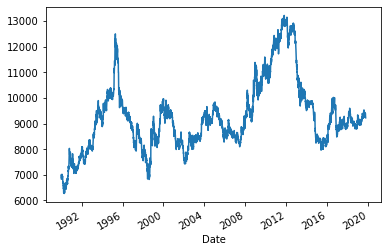

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures['Settle'].plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
# hodrick prescott filter
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_df = pd.DataFrame(yen_futures['Settle'])
yen_df['noise'] = yen_noise
yen_df['trend'] = yen_trend
yen_df.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:xlabel='Date'>

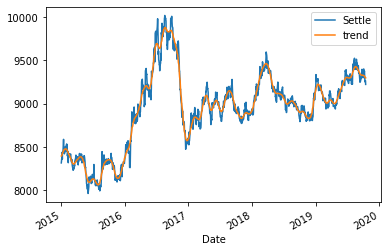

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_df[['Settle', 'trend']].loc['2015':].plot()

<AxesSubplot:xlabel='Date'>

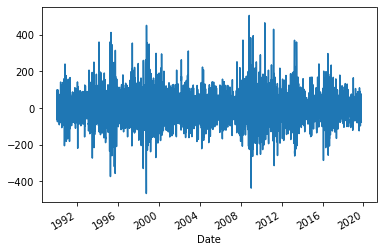

In [8]:
# Plot the Settle Noise
yen_df['noise'].plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA  
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns["Settle"].values, order=(2,1))

/Users/jimmybrown/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [11]:
# Fit the model and assign it to a variable called results
results = model.fit()

In [12]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Fri, 09 Jul 2021   AIC                          15798.142
Time:                        16:42:23   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3060      1.278     -0.239      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2944      1.278      0.230      0.818      -2.210       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3375           +0.0000j            3.3375            0.5000
AR.2         -157.2840           +0.0000j          157.2840            0.5000
MA.1           -3.3966           +0.0000j            3.3966            0.5000
-----------------------------------------------------------------------------
"""

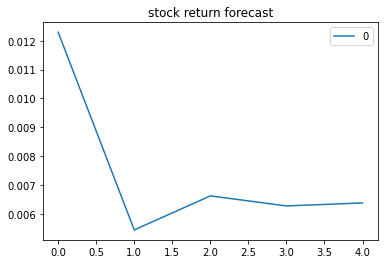

In [13]:
# Plot the 5 Day Returns Forecast
prediction_5days = pd.DataFrame(results.forecast(steps=5)[0]).plot(title='stock return forecast')

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [14]:
from statsmodels.tsa.arima_model import ARIMA

returns2 = (yen_futures[["Settle"]].pct_change() * 100)
returns2 = returns2.replace(-np.inf, np.nan).dropna()
returns2.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [15]:
# ADF Test 
result2 = adfuller(yen_futures['Settle'], autolag='AIC')
print(f'ADF Statistic: {result2[0]}')
print(f'n_lags: {result2[1]}')
print(f'p_value: {result2[1]}')
for key, value in result2[4].items():
        print('Critical Values:')
        print(f' {key}, {value}')

# Ho: it is non-stationary
# Ha: it is stationary

# if p value > alpha (0.05 = 5%), probably null is true
# if ADF stat > critical values, probably null is true

ADF Statistic: -2.4151247020844737
n_lags: 0.13751299771595055
p_value: 0.13751299771595055
Critical Values:
 1%, -3.431220579634037
Critical Values:
 5%, -2.861924730395352
Critical Values:
 10%, -2.566974787574595


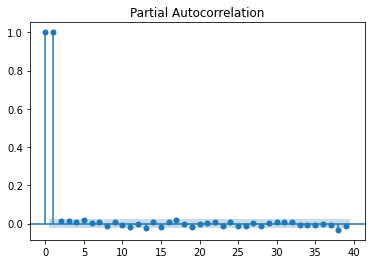

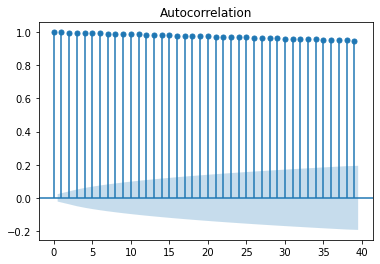

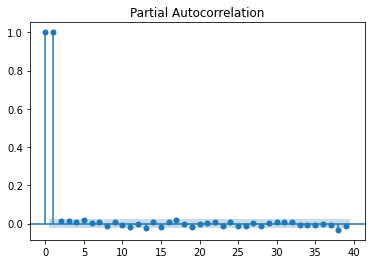

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(yen_futures['Settle'])
plot_pacf(yen_futures['Settle'])

In [18]:
from statsmodels.tsa.arima_model import ARIMA

In [19]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model2=ARIMA(yen_futures["Settle"], order=(5,1,1))

# Fit the model
results2=model2.fit()
results2.summary()

/Users/jimmybrown/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/jimmybrown/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Fri, 09 Jul 2021   AIC                          83905.238
Time:                        16:43:27   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.Settle     0.2826      0.699      0.404      0.686      -1.087       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.965      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0011      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2976      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8922           -1.3782j            2.3410           -0.1002
AR.2            1.8922           +1.3782j            2.3410            0.1002
AR.3           -2.2725           -3.0188j            3.7785           -0.3527
AR.4           -2.2725           +3.0188j            3.7785            0.3527
AR.5          -11.1557           -0.0000j           11.1557           -0.5000
MA.1            3.3597           +0.0000j            3.3597            0.0000
-----------------------------------------------------------------------------
"""

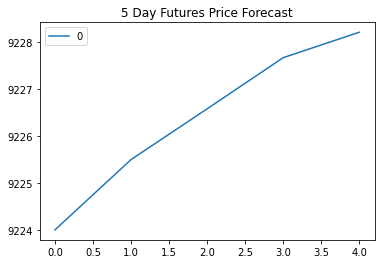

In [20]:
# Plot the 5 Day Price Forecast
prediction2_5days=pd.DataFrame(results2.forecast(steps=5)[0]).plot(title='5 Day Futures Price Forecast')

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [21]:
import arch 
from arch import arch_model

In [22]:
# Estimate a GARCH model:
modelg=arch_model(returns,mean='Zero', vol="GARCH")

# Fit the model
resultsg=modelg.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 7907.752569069989
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7499.999539388455
Iteration:      3,   Func. Count:     15,   Neg. LLF: 7526.127796070408
Iteration:      4,   Func. Count:     20,   Neg. LLF: 7507.683271628448
Iteration:      5,   Func. Count:     25,   Neg. LLF: 7492.0881461035715
Iteration:      6,   Func. Count:     30,   Neg. LLF: 7502.09587155129
Iteration:      7,   Func. Count:     35,   Neg. LLF: 12576.142075672902
Iteration:      8,   Func. Count:     41,   Neg. LLF: 7462.596857255197
Iteration:      9,   Func. Count:     46,   Neg. LLF: 7462.263687846594
Iteration:     10,   Func. Count:     51,   Neg. LLF: 7461.927648765221
Iteration:     11,   Func. Count:     55,   Neg. LLF: 7461.927640083815
Iteration:     12,   Func. Count:     58,   Neg. LLF: 7461.927640081942
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7461.927640083815
            Iterations: 12


In [23]:
# Summarize the model results
resultsg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Fri, Jul 09 2021   Df Residuals:                     7514
Time:                        16:43:40   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

In [24]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

/Users/jimmybrown/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


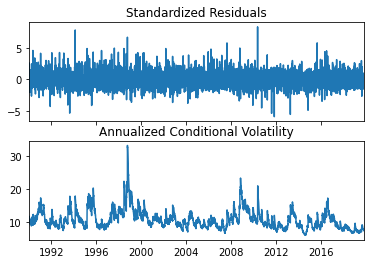

In [25]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
fig = resultsg.plot(annualize='D')
forecasts=resultsg.forecast(horizon=5)
forecasts

In [26]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434026,7.475721,7.516842,7.5574,7.597407


In [27]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434026
h.2,7.475721
h.3,7.516842
h.4,7.557400
h.5,7.597407


<AxesSubplot:>

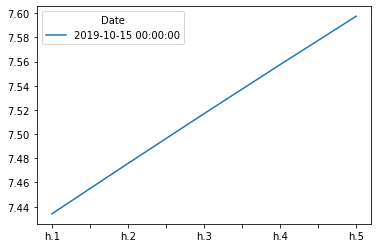

In [28]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now? 
    No, now is not a good time to buy. 

Is the risk of the yen expected to increase or decrease? 
    Yes, as shown in the GARCH, the risk is expected to increase

Based on the model evaluation, would you feel confident in using these models for trading? 
    Yes, I believe the models are good. 